<a href="https://colab.research.google.com/github/Saha555339/Classification/blob/main/LAB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
!wget -O Classification.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv

--2023-10-20 14:40:10--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5827 (5.7K) [text/csv]
Saving to: ‘Classification.csv’

Classification.csv  100%[===================>]   5.69K  --.-KB/s    in 0s      

2023-10-20 14:40:11 (1.52 GB/s) - ‘Classification.csv’ saved [5827/5827]



In [ ]:
data = pd.read_csv("./Classification.csv")
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
cat_cols = ['Sex', 'BP', 'Cholesterol']

target_col = 'Drug'

num_cols = ['Na_to_K', 'Age']

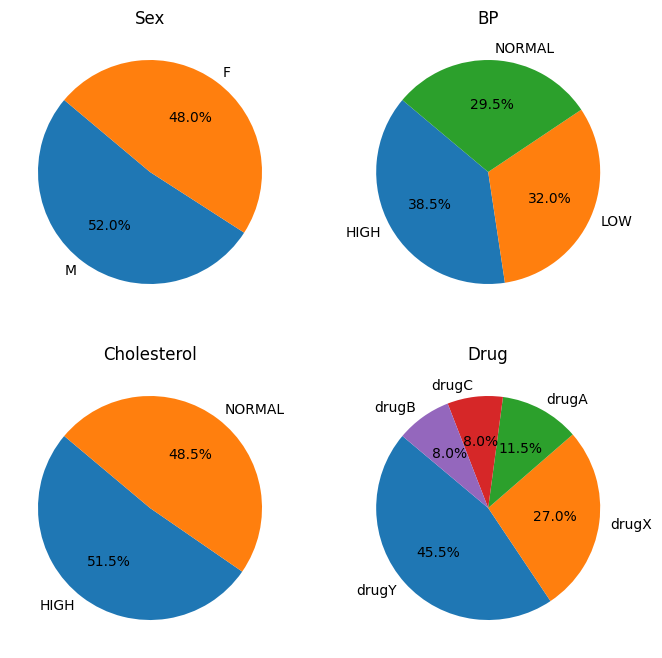

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cat_cols_targ = cat_cols.copy()
cat_cols_targ.append(target_col)

c_i = 0

for i, ax in enumerate(axes.ravel()):
  category_counts = data[cat_cols_targ[c_i]].value_counts()
  ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
  ax.set_title(cat_cols_targ[c_i])

  c_i += 1

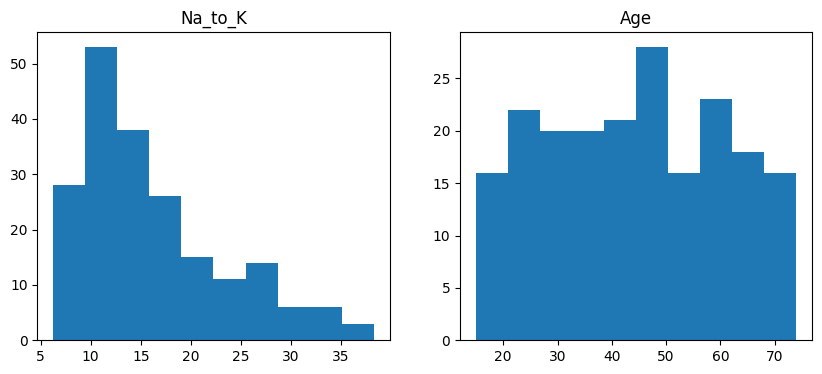

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

n_i = 0
for i, ax in enumerate(axes.ravel()):
  ax.hist(data[num_cols[i]])
  ax.set_title(num_cols[i])

  n_i+=1

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

In [ ]:
X = data.drop(columns='Drug')
y = data['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(160, 5)

In [ ]:
preprocessing = ColumnTransformer(
        transformers=[
            ("cat_cols", OneHotEncoder(), cat_cols),
            ("num_cols", StandardScaler(), num_cols)
        ]
)

pipeline = make_pipeline(
    (preprocessing),
    (KNeighborsClassifier(n_neighbors=5))
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_cols', OneHotEncoder(),
                                                  ['Sex', 'BP', 'Cholesterol']),
                                                 ('num_cols', StandardScaler(),
                                                  ['Na_to_K', 'Age'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
y_pred = pipeline.predict(X_test)

y_pred[:5]

array(['drugX', 'drugY', 'drugX', 'drugC', 'drugY'], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(y_pred, y_test)}")

Accuracy: 0.9


In [ ]:
param_grid = {
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', refit=True)

grid_search.fit(X, y)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__weights': 'distance'}
Лучшая оценка: 0.8799999999999999


In [ ]:
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_pred, y_test)}")

Accuracy: 0.9


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.8991758241758241


In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=data['Drug'].unique())

conf_matrix

array([[12,  0,  1,  1,  1],
       [ 0,  5,  0,  0,  0],
       [ 1,  0, 10,  0,  0],
       [ 0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  3]])

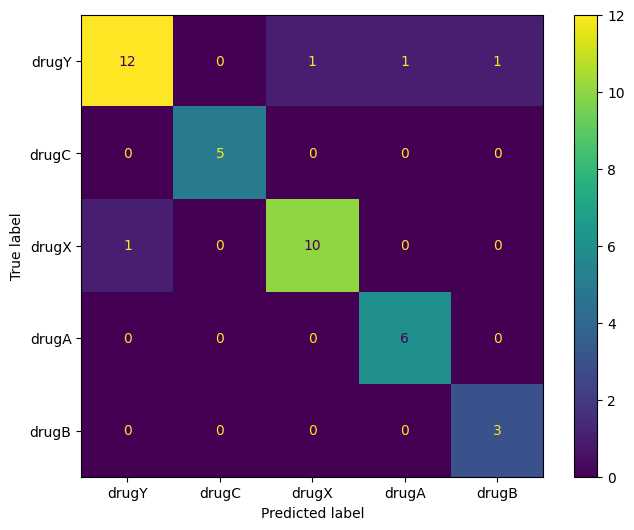

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=data['Drug'].unique())
display.plot(ax=ax);

In [ ]:
preprocessing_cb = ColumnTransformer(
    transformers=[
        ('num_cols', StandardScaler(), num_cols),
        ('cat', 'passthrough', cat_cols)
    ]
)

pipeline_cb = make_pipeline(
    preprocessing,
    CatBoostClassifier(verbose=0, iterations=500, depth=10)
)

pipeline_cb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_cols', OneHotEncoder(),
                                                  ['Sex', 'BP', 'Cholesterol']),
                                                 ('num_cols', StandardScaler(),
                                                  ['Na_to_K', 'Age'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7aa60410f430>)])

In [ ]:
y_pred_cb = pipeline_cb.predict(X_test)

print(f"Accuracy: {accuracy_score(y_pred_cb, y_test)}")
print(f"F1-score: {f1_score(y_pred_cb, y_test, average='weighted')}")

Accuracy: 1.0
F1-score: 1.0
